In [1]:
from hyperoptimization import *

In [40]:
# Some important constants

BATCH_SIZE = 64
PW = 10
ASK_AVG = False
provide_avg = False
denormalize_output = False
keep_time = True
VERBOSE = False

# Flags of current run
COLUMN_MULTIPLIER = True
USE_DF = True

In [23]:
data_filename = 'data/BTCBUSD_CandlestickHist.csv'

In [24]:
# Data preparation\separation

if COLUMN_MULTIPLIER:
    data_filename = column_multiplier(filename=data_filename,
                                      ignore_time=True,
                                      time_col='Time',
                                      backward=False,
                                      sep=';',
                                      dtype='float64',
                                      )

filename_train, filename_test = train_test_split_by_days(filename=data_filename,
                                                         train_days=30,
                                                         test_days=5,
                                                         window=PW,
                                                         time_step=(60000, 'ms'),
                                                         to_the_end=True)


************************
STARTING DATA DIVISION
************************

Columns of original Data and columns of Multipliers correspondingly:
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Time'], dtype='object') ['Open', 'High', 'Low', 'Close', 'Volume']
Original Data Head:
      Open     High      Low    Close  Volume          Time
0  36060.5  36060.5  36060.5  36060.5   0.469  1.610435e+12
1  36042.0  36042.0  36042.0  36042.0   0.001  1.610435e+12
2  36042.0  36042.0  35856.5  35856.5   0.906  1.610435e+12
3  35829.1  35843.3  35824.0  35843.3   4.397  1.610435e+12
4  35834.3  35848.1  35807.9  35815.6   4.650  1.610435e+12
Multipliers Head:
                 Open     High      Low    Close  Volume
general_mean  41184.0  41208.0  41160.0  41184.0    25.0
general_std   12297.0  12302.0  12292.0  12297.0    59.0
max_std_mean  41184.0  41208.0  41160.0  41184.0    59.0
File with column multipliers saved as: data/column_multiplier/column_multiplier_BTCBUSD_CandlestickHist.csv
New D

In [ ]:
I = 0

In [25]:
# Defining search-spaces

space_adam_ = {
    'adam_lr': hp.loguniform('adam_lr', -16, 0),
    'adam_b1': hp.loguniform('adam_b1', -0.7, 0),
    'adam_b2': hp.loguniform('adam_b2', -0.7, 0),
}

space_hf_ = {
    'hf_lr': hp.uniform('hf_lr', 0.9, 1),
}

In [26]:
# Defining columns

# feature_cols = ['o', 'c', 'h', 'l', 'v', 'V', 'n', 'q', 'Q']
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
target_cols = feature_cols
# loss_mask = [4, 5, 6, 7, 8]
loss_mask = [4]
inp_size = len(feature_cols)
time_col = 'Time'

In [71]:
# Creating Model Architecture, Loss, Acc, Datasets

model_ = Model(inp_size, inp_size, [("LSTMCell", {"input_size": inp_size, "hidden_size": 512}),
                                    ("Linear", {"in_features": 512, "out_features": 256}),
                                    ("LSTMCell", {"input_size": 256, "hidden_size": 256}),
                                    ("Linear", {"in_features": 256, "out_features": 128}),
                                    ("LSTMCell", {"input_size": 128, "hidden_size": 128}),
                                    ("Linear", {"in_features": 128, "out_features": 64}),
                                    ("Linear", {"in_features": 64, "out_features": inp_size})],
                   revin_params={}, ask_avg=ASK_AVG)

criterion_ = XTanhLoss()
criterion_ = MaskedLoss(input_size=inp_size, loss=criterion_, unused_cols=loss_mask)

acc_ = MaskedLoss(input_size=inp_size, loss=MSE(), unused_cols=loss_mask)

if USE_DF:
    train_df = pd.read_csv(filename_train, header=0, sep=';', dtype='float64')
    test_df = pd.read_csv(filename_test, header=0, sep=';', dtype='float64')

    train_dataset = KlineDataset(target_cols=target_cols, feature_cols=feature_cols, provide_avg=provide_avg,
                                 denormalize_output=denormalize_output,
                                 time_col=time_col, keep_time=keep_time, data=train_df, prediction_window=PW)
    test_dataset = KlineDataset(target_cols=target_cols, feature_cols=feature_cols, provide_avg=provide_avg,
                                denormalize_output=denormalize_output,
                                time_col=time_col, keep_time=keep_time, data=test_df, prediction_window=PW)
else:
    train_dataset = KlineDataset(target_cols=target_cols, feature_cols=feature_cols, provide_avg=provide_avg,
                                 denormalize_output=denormalize_output,
                                 time_col=time_col, keep_time=keep_time, data_file=filename_train, prediction_window=PW)
    test_dataset = KlineDataset(target_cols=target_cols, feature_cols=feature_cols, provide_avg=provide_avg,
                                denormalize_output=denormalize_output,
                                time_col=time_col, keep_time=keep_time, data_file=filename_test, prediction_window=PW)

DATA = [
    train_dataset,
    test_dataset
]

In [72]:
# Run comparison of HF and Adam

N_EPOCH = 8
N_ITER = 8

adam_trials, hf_trials, adam_best, hf_best = compare_hf_adam(
    model=model_,
    criterion=criterion_,
    accuracy=acc_,
    dataloaders=DATA,
    n_epoch=N_EPOCH,
    space_adam=space_adam_,
    space_hf=space_hf_,
    batch_size=BATCH_SIZE,
    n_iter=N_ITER,
)

I += 1

  0%|                                                                                                                                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:08<?, ?it/s]


  5%|███████▊                                                                                                                                                     | 1/20 [01:08<21:32, 68.02s/trial, best loss: 1.0733130741466559e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:09<?, ?it/s]


 10%|███████████████▊                                                                                                                                              | 2/20 [02:17<20:40, 68.93s/trial, best loss: 8.957935894102823e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:08<?, ?it/s]


 15%|███████████████████████▋                                                                                                                                      | 3/20 [03:26<19:32, 68.96s/trial, best loss: 8.763596420031975e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [02:19<?, ?it/s]


 20%|███████████████████████████████▌                                                                                                                              | 4/20 [05:46<25:51, 96.97s/trial, best loss: 8.763596420031975e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:07<?, ?it/s]


 25%|███████████████████████████████████████▌                                                                                                                      | 5/20 [06:54<21:36, 86.42s/trial, best loss: 8.763596420031975e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:07<?, ?it/s]


 30%|███████████████████████████████████████████████▍                                                                                                              | 6/20 [08:01<18:40, 80.05s/trial, best loss: 8.715941936958466e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:07<?, ?it/s]


 35%|███████████████████████████████████████████████████████▎                                                                                                      | 7/20 [09:09<16:26, 75.89s/trial, best loss: 8.715941936958466e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:08<?, ?it/s]


 40%|███████████████████████████████████████████████████████████████▏                                                                                              | 8/20 [10:17<14:41, 73.44s/trial, best loss: 8.715941936958466e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:06<?, ?it/s]


 45%|███████████████████████████████████████████████████████████████████████                                                                                       | 9/20 [11:24<13:05, 71.40s/trial, best loss: 8.715941936958466e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:07<?, ?it/s]


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 10/20 [12:32<11:42, 70.26s/trial, best loss: 8.389993547578028e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:07<?, ?it/s]


 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11/20 [13:39<10:24, 69.35s/trial, best loss: 8.389993547578028e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:07<?, ?it/s]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12/20 [14:46<09:09, 68.68s/trial, best loss: 8.389993547578028e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:07<?, ?it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13/20 [15:53<07:57, 68.24s/trial, best loss: 8.389993547578028e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:07<?, ?it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 14/20 [17:01<06:47, 68.00s/trial, best loss: 8.389993547578028e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:07<?, ?it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 15/20 [18:08<05:39, 67.90s/trial, best loss: 8.389993547578028e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:51<?, ?it/s]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 16/20 [20:00<05:24, 81.06s/trial, best loss: 8.389993547578028e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:11<?, ?it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 17/20 [21:11<03:54, 78.08s/trial, best loss: 8.389993547578028e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:09<?, ?it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 18/20 [22:20<02:30, 75.42s/trial, best loss: 8.389993547578028e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [02:01<?, ?it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 19/20 [24:22<01:29, 89.39s/trial, best loss: 8.389993547578028e-07]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [01:08<?, ?it/s]


  0%|                                                                                                                                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:46<?, ?it/s]


  5%|███████▋                                                                                                                                                  | 1/20 [06:46<2:08:37, 406.19s/trial, best loss: 1.2817276569499132e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:46<?, ?it/s]


 10%|███████████████▌                                                                                                                                           | 2/20 [13:33<2:01:59, 406.64s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:47<?, ?it/s]


 15%|███████████████████████▎                                                                                                                                   | 3/20 [20:20<1:55:16, 406.86s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:48<?, ?it/s]


 20%|███████████████████████████████                                                                                                                            | 4/20 [27:08<1:48:39, 407.47s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:46<?, ?it/s]


 25%|██████████████████████████████████████▊                                                                                                                    | 5/20 [33:55<1:41:48, 407.21s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:46<?, ?it/s]


 30%|██████████████████████████████████████████████▌                                                                                                            | 6/20 [40:42<1:34:58, 407.04s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:46<?, ?it/s]


 35%|██████████████████████████████████████████████████████▎                                                                                                    | 7/20 [47:28<1:28:08, 406.78s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:46<?, ?it/s]


 40%|██████████████████████████████████████████████████████████████                                                                                             | 8/20 [54:14<1:21:18, 406.56s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:54<?, ?it/s]


 45%|████████████████████████████████████████████████████████████████████▊                                                                                    | 9/20 [1:01:09<1:15:00, 409.11s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:51<?, ?it/s]


 50%|████████████████████████████████████████████████████████████████████████████                                                                            | 10/20 [1:08:00<1:08:17, 409.71s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [07:33<?, ?it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████▌                                                                    | 11/20 [1:15:33<1:03:27, 423.05s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [07:37<?, ?it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12/20 [1:23:11<57:48, 433.60s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [07:35<?, ?it/s]


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13/20 [1:30:47<51:22, 440.32s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [07:36<?, ?it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 14/20 [1:38:23<44:31, 445.32s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [07:30<?, ?it/s]


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 15/20 [1:45:54<37:14, 446.93s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [07:09<?, ?it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 16/20 [1:53:03<29:26, 441.54s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:46<?, ?it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 17/20 [1:59:50<21:33, 431.14s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:42<?, ?it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 18/20 [2:06:33<14:05, 422.60s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:40<?, ?it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 19/20 [2:13:14<06:56, 416.07s/trial, best loss: 1.281727650976324e-06]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [00:00<?, ?it/s]

epoch:   0%|                                                                                                                                                                                                     | 0/8 [06:40<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [2:19:54<00:00, 419.71s/trial, best loss: 1.281727650976324e-06]


In [73]:
# Saving calculated Trials for future analysis

with open(f'trials/hf_adam_compare/Adam_Trials_{I}.obj', 'wb') as adam_trials_file:
    pickle.dump(adam_trials, adam_trials_file)
with open(f'trials/hf_adam_compare/HF_Trials_{I}.obj', 'wb') as hf_trials_file:
    pickle.dump(hf_trials, hf_trials_file)

print('ADAM')
print('Best: ', adam_best)
# print(adam_trials.results)
# print(adam_trials.losses())
# print(adam_trials.statuses())

print('HF')
print('Best: ', hf_best)
# print(hf_trials.results)
# print(hf_trials.losses())
# print(hf_trials.statuses())

ADAM
Best:  {'adam_b1': 0.7726922337449729, 'adam_b2': 0.7837036134641777, 'adam_lr': 0.0025071241311313123}
HF
Best:  {'hf_lr': 0.9323380549759399}


In [ ]:
# ADAM
# Best:  {'adam_b1': 0.5194085461666494, 'adam_b2': 0.8182627929015678, 'adam_lr': 0.0005427854695293583}
# HF
# Best:  {'hf_lr': 0.9364674957353213}

In [74]:
min(adam_trials.losses()), min(hf_trials.losses())

(8.389993547578028e-07, 1.281727650976324e-06)

In [75]:
# (8.259116518324623e-07, 1.3728091171685216e-06)

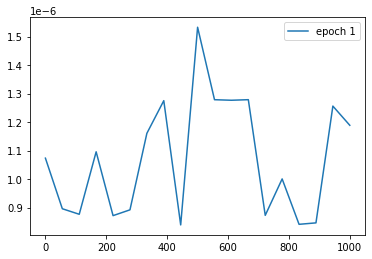

In [89]:
plot_group([i for i in adam_trials.losses() if i < 1.])

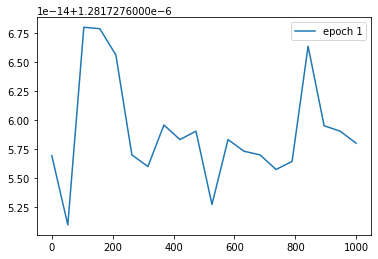

In [77]:
plot_group(hf_trials.losses())

In [78]:
__min_loss = 100.
adam_best_losses = None
for res in adam_trials.results:
    if res['loss'] < __min_loss:
        adam_best_losses = res['losses']

hf_best_losses = None
for res in hf_trials.results:
    if res['loss'] < __min_loss:
        hf_best_losses = res['losses']

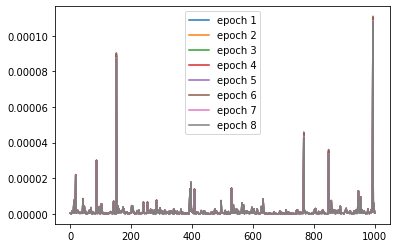

In [79]:
plot_group(adam_best_losses)

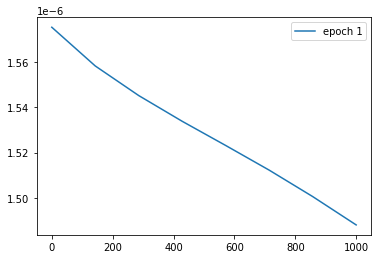

In [80]:
adam_best_loss_by_epoch = [sum(loss) / len(loss) for loss in adam_best_losses]
plot_group(adam_best_loss_by_epoch)

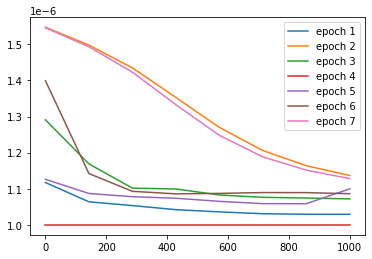

In [92]:
adam_loss_by_epoch = []
for res in adam_trials.results:
    adam_loss_by_epoch.append([sum(loss) / len(loss) if sum(loss) / len(loss) < 1. else 1.0e-6 for loss in res['losses']])
plot_group(adam_loss_by_epoch[:7])

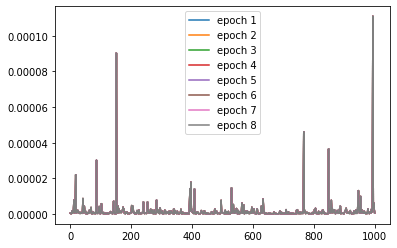

In [82]:
plot_group(hf_best_losses)

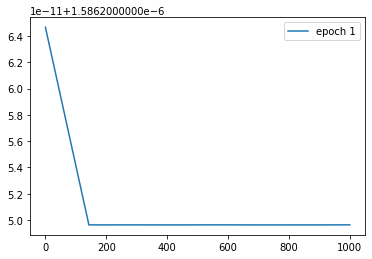

In [83]:
hf_best_loss_by_epoch = [sum(loss) / len(loss) for loss in hf_best_losses]
plot_group(hf_best_loss_by_epoch)

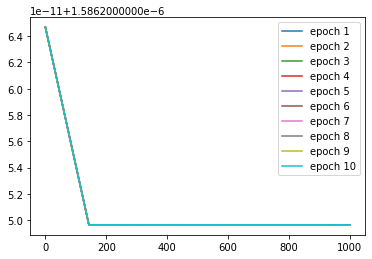

In [84]:
hf_loss_by_epoch = []
for res in hf_trials.results:
    hf_loss_by_epoch.append([sum(loss) / len(loss) for loss in res['losses']])
plot_group(hf_loss_by_epoch[:10])

In [91]:
print(hf_loss_by_epoch[0], hf_loss_by_epoch[1])

[1.5862646754553849e-06, 1.5862496368341722e-06, 1.5862496348762323e-06, 1.5862496348551793e-06, 1.586249632970925e-06, 1.5862496401184586e-06, 1.5862496342025326e-06, 1.5862496347078074e-06] [1.5862646706973801e-06, 1.5862496317708975e-06, 1.586249630728768e-06, 1.5862496305287635e-06, 1.5862496328867126e-06, 1.58624963087614e-06, 1.5862496310550913e-06, 1.5862496288550406e-06]


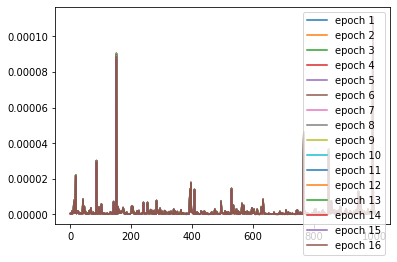

In [85]:
plot_group(hf_best_losses + adam_best_losses)

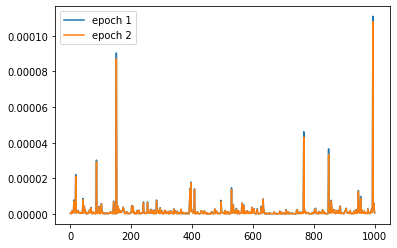

In [86]:
plot_group([hf_best_losses[-1], adam_best_losses[-1]])

In [115]:
model_ = Model(inp_size, inp_size, [("LSTMCell", {"input_size": inp_size, "hidden_size": 512}),
                                    ("Linear", {"in_features": 512, "out_features": 256}),
                                    ("LSTMCell", {"input_size": 256, "hidden_size": 256}),
                                    ("Linear", {"in_features": 256, "out_features": 128}),
                                    ("LSTMCell", {"input_size": 128, "hidden_size": 128}),
                                    ("Linear", {"in_features": 128, "out_features": 64}),
                                    ("Linear", {"in_features": 64, "out_features": inp_size})],
                   revin_params={}, ask_avg=ASK_AVG)

criterion_ = XTanhLoss()
criterion_ = MaskedLoss(input_size=inp_size, loss=criterion_, unused_cols=loss_mask)

acc_ = MaskedLoss(input_size=inp_size, loss=MSE(), unused_cols=loss_mask)

In [116]:
for i, par in enumerate(model_.parameters()):
    print(i)
    print(par)
    if i > 5:
        break

0
Parameter containing:
tensor([[-0.0162,  0.0311, -0.0058,  0.0335,  0.0114],
        [-0.0328, -0.0050,  0.0109, -0.0425, -0.0113],
        [-0.0096,  0.0327, -0.0080,  0.0428,  0.0413],
        ...,
        [-0.0313, -0.0069,  0.0040, -0.0130,  0.0383],
        [ 0.0098,  0.0054, -0.0118,  0.0250, -0.0324],
        [-0.0348, -0.0296, -0.0078, -0.0250, -0.0215]], requires_grad=True)
1
Parameter containing:
tensor([[ 0.0232, -0.0232, -0.0191,  ..., -0.0333,  0.0292, -0.0241],
        [-0.0014,  0.0210, -0.0079,  ...,  0.0428, -0.0186, -0.0398],
        [ 0.0038,  0.0351,  0.0185,  ...,  0.0353,  0.0168, -0.0250],
        ...,
        [ 0.0340,  0.0407, -0.0026,  ...,  0.0323, -0.0352, -0.0107],
        [ 0.0088,  0.0414,  0.0423,  ..., -0.0418, -0.0364,  0.0075],
        [ 0.0421, -0.0274,  0.0374,  ..., -0.0364,  0.0174, -0.0156]],
       requires_grad=True)
2
Parameter containing:
tensor([-0.0090, -0.0045, -0.0149,  ..., -0.0302,  0.0284, -0.0326],
       requires_grad=True)
3
Param

In [118]:
losses, accs = train(model=model_,
#                      optimizer=HFWrapper(model_, criterion_, HessianFree(model_.parameters(), lr=1.),
#                                          use_DAIN=False),
                     optimizer=torch.optim.Adam(model_.parameters(), lr=0.5),
                     criterion=criterion_,
                     scorer=acc_,
                     dataloaders=DATA,
                     n_epochs=16,
                     batch_size=64,
                     verbose=False,
                     HF=False,
                     keep_best=False,
                     )

epoch:   0%|                                                                                                                                                                                                    | 0/16 [05:21<?, ?it/s]


In [119]:
for i, par in enumerate(model_.parameters()):
    print(i)
    print(par)
    if i > 5:
        break

0
Parameter containing:
tensor([[-0.0074,  0.0476,  0.0726,  0.0216,  0.3325],
        [-0.1251, -0.0175, -0.1543, -0.0083, -0.4810],
        [-0.0359,  0.0528, -0.0655,  0.0714,  0.0055],
        ...,
        [-0.0344, -0.0268,  0.0226, -0.0370,  0.0360],
        [-0.1202,  0.0429, -0.2407,  0.1334, -0.6941],
        [-0.0082, -0.0154,  0.0762, -0.0380,  0.3092]], requires_grad=True)
1
Parameter containing:
tensor([[ 0.0758, -0.0654, -0.0408,  ..., -0.0225,  0.0720, -0.0508],
        [-0.1013,  0.1052,  0.0358,  ...,  0.0201, -0.1043,  0.0108],
        [-0.0324,  0.0653,  0.0344,  ...,  0.0269, -0.0139, -0.0070],
        ...,
        [ 0.0521,  0.0257, -0.0101,  ...,  0.0362, -0.0199, -0.0197],
        [-0.1516,  0.1800,  0.1127,  ..., -0.0781, -0.1785,  0.0894],
        [ 0.0965, -0.0727,  0.0147,  ..., -0.0250,  0.0637, -0.0430]],
       requires_grad=True)
2
Parameter containing:
tensor([-0.8613,  1.1464,  0.5309,  ..., -0.3513,  1.4713, -0.8476],
       requires_grad=True)
3
Param

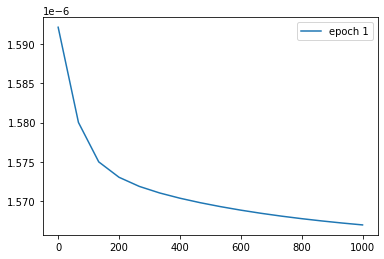

In [120]:
def mean(x):
    return sum(x) / len(x)

plot_group([mean(i) for i in losses])

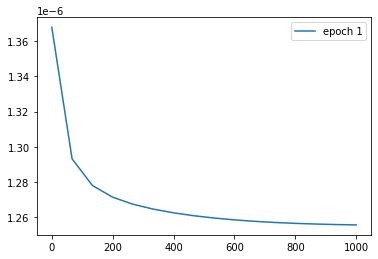

In [121]:
plot_group([mean(i) for i in accs])